In [1]:
# Run this again after editing submodules so Colab uses the updated versions
from citylearn import  CityLearn
from pathlib import Path
from agent import Agent
from copy import deepcopy
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


import matplotlib.pyplot as plt


import utils
import time

import numpy as np    
import pandas as pd
import torch

# Load environment
climate_zone = 5
params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': (0, 8760*4-1), 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()


params_agent = {'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
                 'buildings_states_actions':'buildings_state_action_space.json', 
                 'building_info':building_info,
                 'observation_space':observations_spaces, 
                 'action_spaces':actions_spaces}

# Instantiating the control agent(s)
agents = Agent(**params_agent)

RBC_THRESHOLD = 24*14
# agents = Agent(
#     num_actions=actions_spaces,
#     num_buildings=len(observations_spaces),
#     env = env, is_oracle = False,
# )

state = env.reset()
done = False

action = agents.select_action(state, False)
costs_peak_net_ele = []

t_idx = 0
# run for a month - NOTE: THIS WILL TAKE ~2 HOURS TO RUN. reduce `end_time` for quicker results.
end_time = RBC_THRESHOLD + 24 * 80

start_time = time.time()



# returns E_grid for RBC agent
E_grid_RBC = utils.RBC(actions_spaces).get_rbc_data(
    deepcopy(env), state, end_time)
E_grid_RBC = np.array(E_grid_RBC)

E_grid_true = []  # see comments below for more info.

while not done and env.time_step < end_time:

    next_state, reward, done, _ = env.step(action)
    action_next = agents.select_action(
        next_state, False
    )  # passing in environment for Oracle agent.

#     agents.add_to_buffer_oracle(state, env, action, reward, next_state)
    agents.add_to_buffer(state, action, reward, next_state, done)
    ## add env E-grid
    E_grid_true.append([x[28] for x in state])
    state = next_state
    action = action_next

    t_idx += 1

    print(f"\rTime step: {t_idx}", end="")

print(
    f"Total time (min) to run {end_time // 24} days of simulation: {round((time.time() - start_time) / 60, 3)}"
)

Time step: 334H dataframe
     Building_0_cap_c  Building_1_cap_c  Building_2_cap_c  Building_3_cap_c  \
0         670.910025        165.653799        450.302103        562.161810   
1         719.035965        166.747029        453.255345        565.894201   
2         724.107481        179.960371        506.813819               NaN   
3         759.700434        181.269609        510.557593               NaN   
4         765.344190        185.862983        514.366555               NaN   
5         728.303875        187.240333        511.641680               NaN   
6         733.478016        181.754034               NaN               NaN   
7         734.870640        205.226000               NaN               NaN   
8         740.166514        209.053476               NaN               NaN   
9         745.506601        181.339016               NaN               NaN   
10               NaN        184.293812               NaN               NaN   
11               NaN        184.00658

In [2]:
agents.memory.get(-1)["C_p_Csto"].shape

(24, 9)

In [3]:
np.shape(agents.costs)

(0,)

In [16]:
x = np.array(agents.all_costs).squeeze(1)

In [23]:
vars_RL = agents.logger
# print(len(vars_RL))
# print(RBC_THRESHOLD)

time_RBC = int(RBC_THRESHOLD/24)
time_sim = int(end_time/24) - time_RBC  # Number of days simulation
time_end = time_sim + time_RBC
print(time_RBC)
print(time_sim)
print(time_end)

# print(np.shape(agents.all_costs))

all_costs = agents.all_costs

all_costs = np.mean(all_costs, axis = 2)

# print(np.shape(all_costs))

p_ele_data = np.array(agents.p_ele_logger)

# print(np.shape(p_ele_data))
# p_ele_data = agents.p_ele_logger.reshape(len(vars_RL)*1*24,9)
# print(np.shape(agents.p_ele_logger))

def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis', aspect = 'auto')
    plt.title('Heatmap Building 4')
    plt.xlabel('days')
    plt.ylabel('hours')
    plt.colorbar()
    plt.show()

# p_ele_data = p_ele_data[:-1,:,:,3]    # Getting data for a certain building 
print(np.shape(p_ele_data))

# p_ele_data = p_ele_data.reshape(time_end, 24)

# plt.figure(figsize = (20,10))
# heatmap2d(p_ele_data[0:100,:].T)

# print(p_ele_data[1,:])
# print(all_costs)



14
80
94
(2257, 1, 24, 9)


(1921, 9)
1921


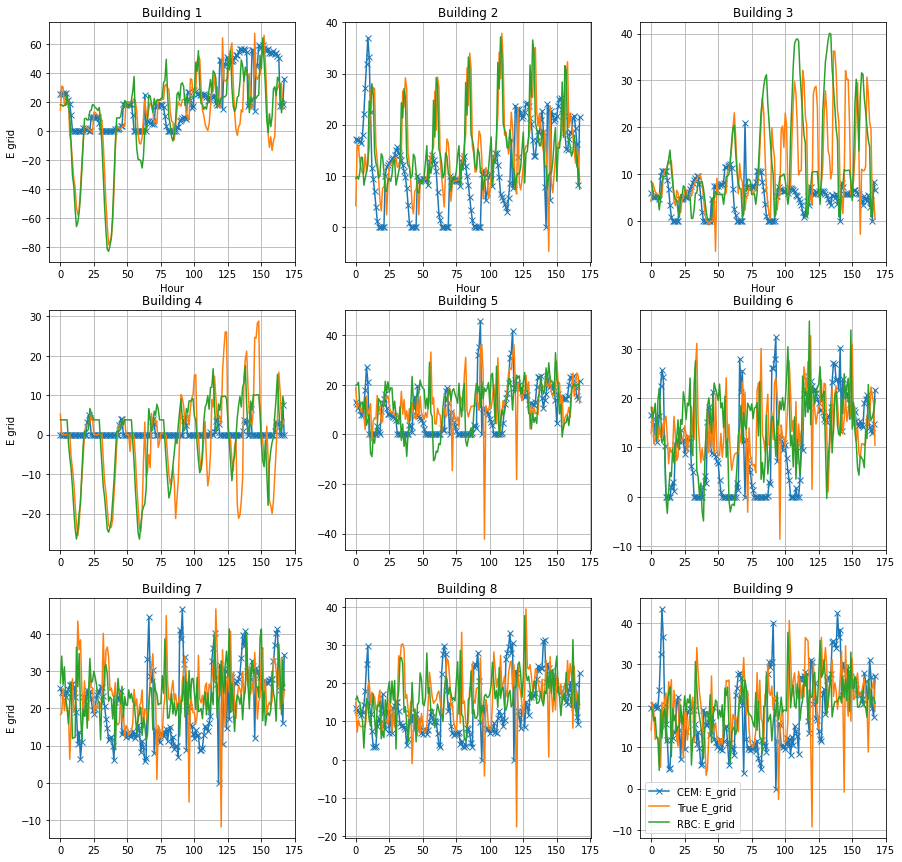

In [34]:
############## TODO: ENTER CODE HERE ##############

# list of dictionary of variables generated from RL. See actor.py#L166 for relevant variable names. eg. vars_RL[0]['E_grid']
# NOTE: dimensions of RL/NORL logger is ≠ RBC. This is because RL/NORL implicitly uses RBC. We only start collecting data from
# RL/NORL once it starts making inference, i.e, after `rbc_threshold`. Tweak the parameter above!


vars_RL = agents.logger
print(np.shape(vars_RL))
print(len(vars_RL))


# list of dictionary of variables generated NORL - Optim w/o any RL. See actor.py#L166 for relevant variable names. eg. vars_RL[0]['E_grid']
# vars_NORL = agents.norl_logger

# true E-grid values. NOTE: E_grid = E_grid_true. E_grid_pred = var["E_grid"] for RL/Optim
E_grid_true = np.array(E_grid_true)

# E_grid net electricity consumption per building using RBC
E_grid_RBC = np.array(E_grid_RBC)

############## TODO: ENTER CODE HERE ##############


# vars_RL = np.array(vars_RL)  # DImension - No.of days
# RL_SOC_C = np.flatten(vars_RL[:]['SOC_C']).reshape(24*30,9)
# RL_SOC_C.append(vars_RL[i]['SOC_C'])

# #If indexing error, use the for loop
# RL_SOC_C.append( vars_RL[i][key] )
# RL_SOC_C = np.array(RL_SOC_C).flatten().reshape(days * 24, 9)


# vars_A, vars_B, ..., vars_Z = [], [], ..., [] # RL
# vars_A, vars_B, ..., vars_Z = [], [], ..., [] # NORL  #Already Defined

# 1. RBC Agent
RBC_actions_arr = []
RBC_look_ahead_cost = []  
RBC_E_grid_pred = []
RBC_E_grid_sell = []
RBC_E_hpC = []
RBC_E_ehH = []
RBC_Edhw = []
RBC_SOC_bat = []
RBC_SOC_C = []
RBC_SOC_H = []
RBC_C_p_bat = []
RBC_C_p_Csto = []
RBC_C_p_Hsto = []
RBC_ramping_cost = []
RBC_peak_electricity_cost = []
RBC_total_cost = []
RBC_action_C = []
RBC_action_H = []
RBC_action_bat = []

# 2. RL Agent
RL_actions_arr = []
RL_look_ahead_cost = [] 
RL_E_grid_sell = []
RL_E_grid_pred = []
RL_E_hpC = []
RL_E_ehH = []
RL_Edhw = []
RL_SOC_bat = []
RL_SOC_H = []
RL_SOC_C = []
RL_C_p_bat = []
RL_C_p_Csto = []
RL_C_p_Hsto = []
RL_ramping_cost = []
RL_peak_electricity_cost = []
RL_total_cost = []
RL_action_C = []
RL_action_H = []
RL_action_bat = []

# 3. NO RL Agent (Just Optimization)
# NORL_actions_arr = []
# NORL_look_ahead_cost = []
# NORL_E_grid_sell = []
# Egrid = []  
# NORL_E_grid_pred = []
# NORL_E_hpC = []
# NORL_E_ehH = []
# NORL_Edhw = []
# NORL_SOC_bat = []
# NORL_SOC_C = []
# NORL_SOC_H = []
# NORL_C_p_bat = []
# NORL_C_p_Csto = []
# NORL_C_p_Hsto = []
# NORL_ramping_cost = []
# NORL_peak_electricity_cost = []
# NORL_total_cost = []
# NORL_action_C = []
# NORL_action_H = []
# NORL_action_bat = []


# keys = list("E_grid", "E_grid_sell", "E_hpC", "E_ehH", "SOC_bat", "SOC_H", "SOC_C", " action_bat", "action_H", "action_C") 



for i in range(len(vars_RL)): #number of days of RL/NORL
    for j in range (9):
#         print('i, j = ', i, j)
        RL_E_grid_pred.append(vars_RL[i][j]["E_grid"])
        RL_E_grid_sell.append(vars_RL[i][j]["E_grid_sell"])
        RL_E_hpC.append(vars_RL[i][j]["E_hpC"])
        RL_E_ehH.append(vars_RL[i][j]['E_ehH'])
        RL_SOC_bat.append(vars_RL[i][j]["SOC_bat"])
        RL_SOC_H.append(vars_RL[i][j]["SOC_H"])
        RL_SOC_C.append(vars_RL[i][j]["SOC_C"])
        RL_action_bat.append(vars_RL[i][j]["action_bat"])
        RL_action_C.append(vars_RL[i][j]["action_C"])
        RL_action_H.append(vars_RL[i][j]["action_H"])
        
    
#         NORL_E_grid_pred.append(vars_NORL[i][j]["E_grid"])
#         NORL_E_grid_sell.append(vars_NORL[i][j]["E_grid_sell"])
#         NORL_E_hpC.append(vars_NORL[i][j]["E_hpC"])
#         NORL_E_ehH.append(vars_NORL[i][j]["E_ehH"])
#         NORL_SOC_bat.append(vars_NORL[i][j]["SOC_bat"])
#         NORL_SOC_H.append(vars_NORL[i][j]["SOC_H"])
#         NORL_SOC_C.append(vars_NORL[i][j]["SOC_C"])
#         NORL_action_bat.append(vars_NORL[i][j]["action_bat"])
#         NORL_action_C.append(vars_NORL[i][j]["action_C"])
#         NORL_action_H.append(vars_NORL[i][j]["action_H"])



# ### flatten out to get hour per building

RL_E_grid_pred = np.array(RL_E_grid_pred).flatten().reshape(-1, 9) # hours x num_buildings
RL_E_grid_sell = np.array(RL_E_grid_sell).flatten().reshape(-1, 9) # hours x num_buildings

# RL_E_grid_pred = np.array(RL_E_grid_pred).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_E_grid_sell = np.array(RL_E_grid_sell).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_E_hpC = np.array(RL_E_hpC).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_E_ehH = np.array(RL_E_ehH).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_SOC_bat = np.array(RL_SOC_bat).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_SOC_H = np.array(RL_SOC_H).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_SOC_C = np.array(RL_SOC_C).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_action_bat = np.array(RL_action_bat).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_action_C = np.array(RL_action_C).flatten().reshape(len(vars_RL), 9) # hours x num_buildings
# RL_action_H = np.array(RL_action_H).flatten().reshape(len(vars_RL), 9) # hours x num_buildings

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        bid = i * 3 + j
        axs[i, j].set_title(f"Building {bid + 1}")
        axs[i, j].plot(
            RL_E_grid_pred[:,i*3+j][-168:] + RL_E_grid_sell[:,i*3+j][-168:], label="CEM: E_grid", marker='x'
        )
        axs[i, j].plot(
            E_grid_true[RBC_THRESHOLD:,i*3+j][-168:], label="True E_grid"
        )  # plot true E grid
        axs[i, j].plot(
            E_grid_RBC[RBC_THRESHOLD:,i*3+j][-168:], label="RBC: E_grid"
        )  # plot true E grid
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("E grid")
        if i == 0:
            axs[i, j].set_xlabel("Hour")



# # plot predicted E_grid
# # week = end_time - 24 * 3  # plots last week of the month data
# fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# for i in range(3):
#     for j in range(3):
#         bid = i * 3 + j
# #         axs[i, j].set_title(f"Building {bid + 1}")
# #         axs[i, j].plot(
# #             NORL_E_grid_pred[:,i*3+j],
# #             label="NORL Egrid",
# #         )   # plots per month
#         axs[i, j].plot(
#              E_grid_RBC[:,i*3+j], label="RBC E grid"
#          )  # plot true E grid
#         axs[i, j].plot(
#              RL_E_grid_pred[:,i*3+j], label="CEM RL_Egrid"
#          )  
#         axs[i, j].grid()
#         if j == 0:
#             axs[i, j].set_ylabel("E grid")
#         if i == 0:
#             axs[i, j].set_xlabel("Hour")
plt.legend()
plt.show()


(2256, 9)
(1921, 9)
0.7892674064128451


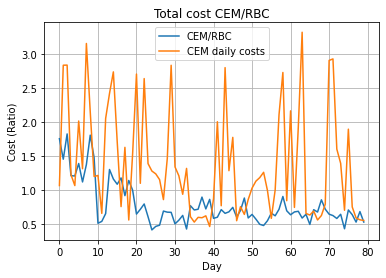

In [25]:
all_costs = agents.all_costs

all_costs = np.mean(all_costs, axis = 2)


time_RBC = int(RBC_THRESHOLD/24)
time_sim = int(end_time/24) - time_RBC  # Number of days simulation
time_end = int(end_time/24)

ramping_cost_CEM = []
ramping_cost_RBC = []
peak_electricity_cost_CEM = []
peak_electricity_cost_RBC = []

a = np.shape(E_grid_RBC)
print(a)
b = np.shape(RL_E_grid_pred)
print(b)

E_grid_RBC_used = E_grid_RBC[RBC_THRESHOLD: end_time,:]
RL_E_grid_pred_used = RL_E_grid_pred[0:24*time_sim,:]

E_grid_RBC_used = E_grid_RBC_used.flatten().reshape(time_sim, 24, 9)
RL_E_grid_pred_used = RL_E_grid_pred_used.flatten().reshape(time_sim,24, 9)


ramping_cost_CEM = []
ramping_cost_RBC = []
peak_electricity_cost_CEM = []
peak_electricity_cost_RBC = []

for i in range(time_sim):
#     t_start = week + i * 24
#     t_end = week + (i + 1) * 24
    ramping_cost_CEM_t = []
    ramping_cost_RBC_t = []
    peak_electricity_cost_CEM_t = []
    peak_electricity_cost_RBC_t = []
    for bid in range(9):
        CEM_E_grid_t = RL_E_grid_pred_used[i,:,bid]
        RBC_Egrid_t = E_grid_RBC_used[i,:,bid]
        ramping_cost_CEM_t.append(np.sum(np.abs(CEM_E_grid_t[1:] - CEM_E_grid_t[:-1])))
        ramping_cost_RBC_t.append(np.sum(np.abs(RBC_Egrid_t[1:] - RBC_Egrid_t[:-1])))
        peak_electricity_cost_CEM_t.append(np.max(CEM_E_grid_t))
        peak_electricity_cost_RBC_t.append(np.max(RBC_Egrid_t))
    ramping_cost_CEM.append(ramping_cost_CEM_t)
    ramping_cost_RBC.append(ramping_cost_RBC_t)
    peak_electricity_cost_CEM.append(peak_electricity_cost_CEM_t)
    peak_electricity_cost_RBC.append(peak_electricity_cost_RBC_t)


CEM_cost = {
    "ramping_cost": np.array(ramping_cost_CEM).T,
    "peak_electricity_cost": np.array(peak_electricity_cost_CEM).T,
    "total_cost": np.array(ramping_cost_CEM).T
    + np.array(peak_electricity_cost_CEM).T,
}
RBC_cost = {
    "ramping_cost": np.array(ramping_cost_RBC).T,
    "peak_electricity_cost": np.array(peak_electricity_cost_RBC).T,
    "total_cost": np.array(ramping_cost_RBC).T + np.array(peak_electricity_cost_RBC).T,
}

item_cost = ["ramping_cost", "peak_electricity_cost", "total_cost"]
# for k in range(len(item_cost)):
#     fig, axs = plt.subplots(3, 3, figsize=(15, 15))
#     for i in range(3):
#         for j in range(3):
#             bid = i * 3 + j
#             axs[i, j].set_title(f"Building {bid + 1}: {item_cost[k]}")
#             axs[i, j].plot(
#                 CEM_cost[item_cost[k]][bid, :], label=f"CEM: {item_cost[k]}"
#             )  # plot true E grid
#             axs[i, j].plot(RBC_cost[item_cost[k]][bid, :], label=f"RBC: {item_cost[k]}")
#             axs[i, j].grid()
#             if j == 0:
#                 axs[i, j].set_ylabel("Cost")
#             if i == 0:
#                 axs[i, j].set_xlabel("Day")
#     plt.legend()

# for k in range(len(item_cost)):
# fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# for i in range(3):
#     for j in range(3):
#         bid = i * 3 + j
#         axs[i, j].set_title(f"Building {bid + 1}: total cost CEM/RBC")
#         axs[i, j].plot(
#             CEM_cost["total_cost"][bid, :] / RBC_cost["total_cost"][bid, :],
#             label=f"CEM/RBC",
#         )  # plot true E grid
#         axs[i, j].grid()
#         if j == 0:
#             axs[i, j].set_ylabel("Cost (Ratio)")
#         if i == 0:
#                 axs[i, j].set_xlabel("Day")
# plt.legend()

# print(all_costs)

fig1, ax1 = plt.subplots()
ax1.set_title(f"Total cost CEM/RBC")
ax1.plot(np.sum(CEM_cost["total_cost"],axis=0) / np.sum(RBC_cost["total_cost"],axis=0),
            label=f"CEM/RBC")  # plot true E grid
ax1.plot(all_costs, label=f"CEM daily costs")
ax1.grid()
ax1.set_ylabel("Cost (Ratio)")
ax1.set_xlabel("Day")
plt.legend()

print(np.mean(np.sum(CEM_cost["total_cost"],axis=0) / np.sum(RBC_cost["total_cost"],axis=0)))



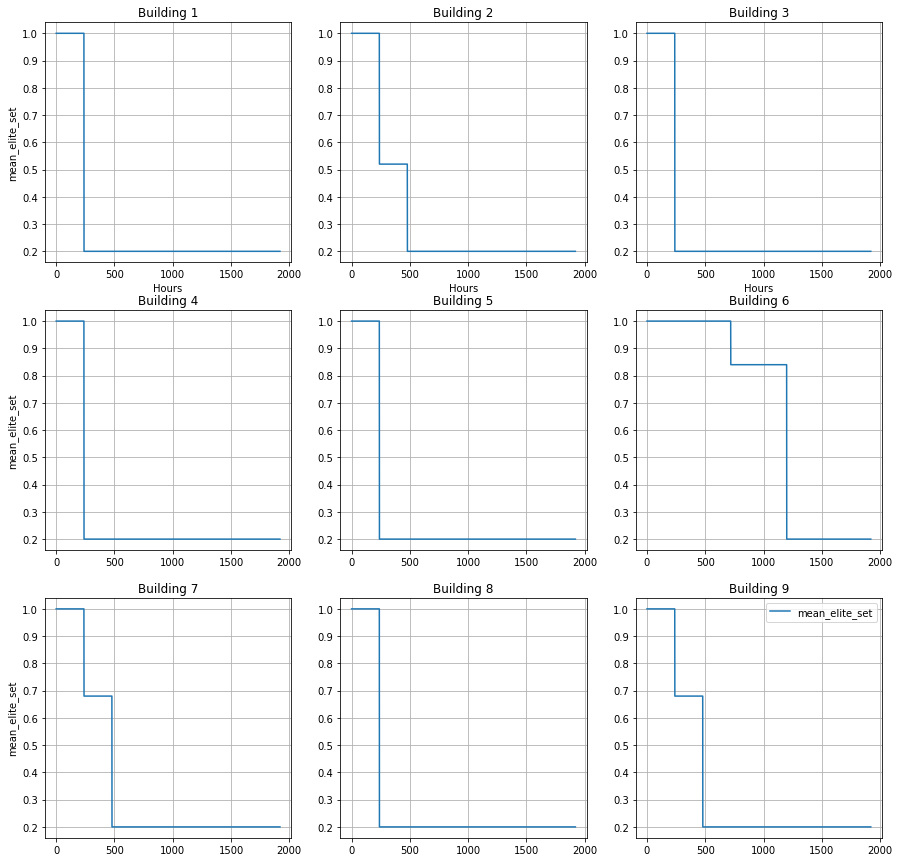

In [26]:
vars_RL = agents.logger
# print(len(vars_RL))

mean_elite_set = np.array(agents.mean_elite_set)

# print(np.shape(agents.mean_elite_set))

# p_ele_data = agents.p_ele_logger.reshape(len(vars_RL)*1*24,9)

# print(np.shape(agents.p_ele_logger))

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        bid = i * 3 + j
        axs[i, j].set_title(f"Building {bid + 1}")
        axs[i, j].plot(
            mean_elite_set[:,i*3+j],
            label="mean_elite_set",
        )   # plots per month
#         axs[i, j].plot(
#              E_grid_RBC[:,i*3+j], label="RBC E grid"
#          )  # plot true E grid
#         axs[i, j].plot(
#              RL_E_grid_pred[:,i*3+j], label="CEM RL_Egrid"
#          )  
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("mean_elite_set")
        if i == 0:
            axs[i, j].set_xlabel("Hours")
plt.legend()
plt.show()

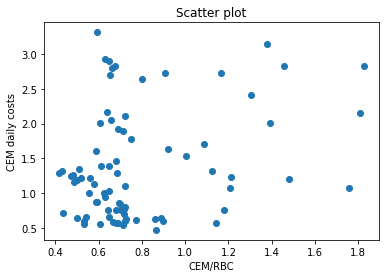

In [27]:
import numpy as np
import matplotlib.pyplot as plt


g1 = np.sum(CEM_cost["total_cost"],axis=0) /np.sum(RBC_cost["total_cost"],axis=0)
g1 = g1[0:365]
g2 = all_costs


plt.scatter(g1, g2)
plt.title('Scatter plot')
plt.xlabel('CEM/RBC')
plt.ylabel('CEM daily costs')
plt.show()




# list_data = list(range(366))
# list_data = tuple(list_data)

# colors = ("red", "green")
# groups = ("CEM/RBC", "CEM daily costs")

# # Create plot
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, facecolor="1.0")



# for i, color, group in zip(list_data, colors, groups):
#     x = g1[i]
#     y = g2[i,:]
#     ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)


# plt.title('Matplot scatter plot')
# plt.legend(loc=2)
plt.show()

In [28]:
np.corrcoef(g1, g2.squeeze(1))

array([[1.        , 0.29346747],
       [0.29346747, 1.        ]])

In [29]:
print(np.shape(all_costs))
print(np.shape(np.sum(CEM_cost["total_cost"],axis=0) / np.sum(RBC_cost["total_cost"],axis=0)))
A = np.sum(CEM_cost["total_cost"],axis=0) /np.sum(RBC_cost["total_cost"],axis=0)
print(np.shape(A[0:365]))

(80, 1)
(80,)
(80,)


In [30]:
time_RBC = int(RBC_THRESHOLD/24)
time_sim = int(end_time/24) - time_RBC  # Number of days simulation

time_end = int(end_time/24)

print(time_sim)
print(time_RBC)
print(time_end)

80
14
94


In [31]:
import numpy as np

zeta_k = 0.2*np.ones(((1,24,9)))

zeta_k[:,0:5,:] = 0.2
zeta_k[:,6:10,:] = 0.4
zeta_k[:,11:14,:] = 2
zeta_k[:,15:17,:] = 3
zeta_k[:,18:21,:] = 0.4
zeta_k[:,22:23,:] = 0.2

print(zeta_k)

[[[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [2.  2.  2.  2.  2.  2.  2.  2.  2. ]
  [2.  2.  2.  2.  2.  2.  2.  2.  2. ]
  [2.  2.  2.  2.  2.  2.  2.  2.  2. ]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [3.  3.  3.  3.  3.  3.  3.  3.  3. ]
  [3.  3.  3.  3.  3.  3.  3.  3.  3. ]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]]]


In [32]:
zeta_k_list = np.ones(((4, 24, 9)))  # 4 different Zetas.

zeta_k_list[0,:,:] = np.ones((24,9))

print(np.shape(zeta_k_list[0,:,:]))

print(zeta_k_list[1,:,:])

(24, 9)
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
